# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

**=> <u>"La métrica RECM en el conjunto de prueba no debe ser superior a 48."</u>**

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

Primero, cargaremos las librerías a utilizar y analizaremos el dataset con el cual vamos a trabajar.

In [1]:
# cargar librerías

import pandas as pd
import datetime as dt

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
# cargar dataset

data = pd.read_csv(
    '/datasets/taxi.csv', index_col=[0], parse_dates=[0]
)

In [3]:
# mostrar dataset

data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [4]:
# revisar si los índices están ordenados

print(data.index.is_monotonic)

True


In [5]:
# revisar info

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
# mostrar índices

data.index

DatetimeIndex(['2018-03-01 00:00:00', '2018-03-01 00:10:00',
               '2018-03-01 00:20:00', '2018-03-01 00:30:00',
               '2018-03-01 00:40:00', '2018-03-01 00:50:00',
               '2018-03-01 01:00:00', '2018-03-01 01:10:00',
               '2018-03-01 01:20:00', '2018-03-01 01:30:00',
               ...
               '2018-08-31 22:20:00', '2018-08-31 22:30:00',
               '2018-08-31 22:40:00', '2018-08-31 22:50:00',
               '2018-08-31 23:00:00', '2018-08-31 23:10:00',
               '2018-08-31 23:20:00', '2018-08-31 23:30:00',
               '2018-08-31 23:40:00', '2018-08-31 23:50:00'],
              dtype='datetime64[ns]', name='datetime', length=26496, freq=None)

Ahora entendemos con qué tipo de dataset estamos trabajando y verificado que no contiene valores nulos, podemos comenzar con el proyecto.

El siguiente paso, graficaremos el comportamiento de la variable objetivo en distintos periodos de tiempo, en horas, días y en meses. Luego, agruparemos los índices en intervalos de 1 hora, con la suma total de los taxis solicitados dentro de cada hora.

In [7]:
# crear función para graficar por periodos de tiempo

time_periods = ['1H','1D','1M']

def plot_taxi_periods(periods,df):
    for period in periods:
        df.resample(period).sum().plot(figsize=[10,5], title=f'Taxis Solicitados por: {period}')

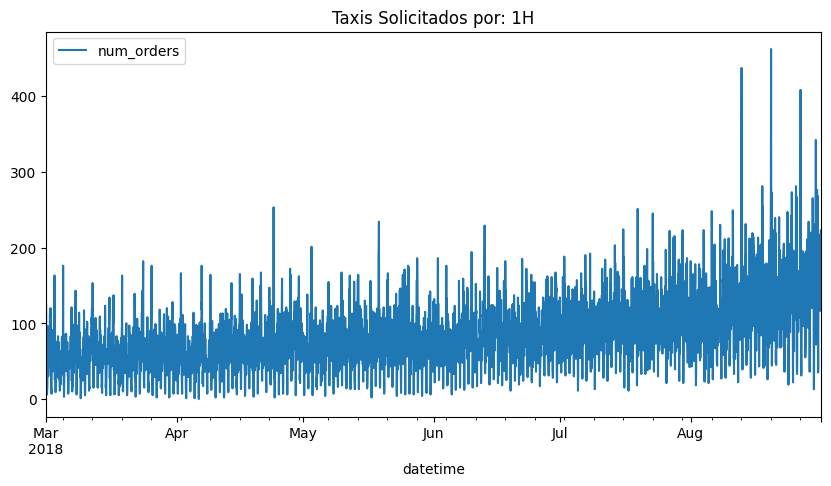

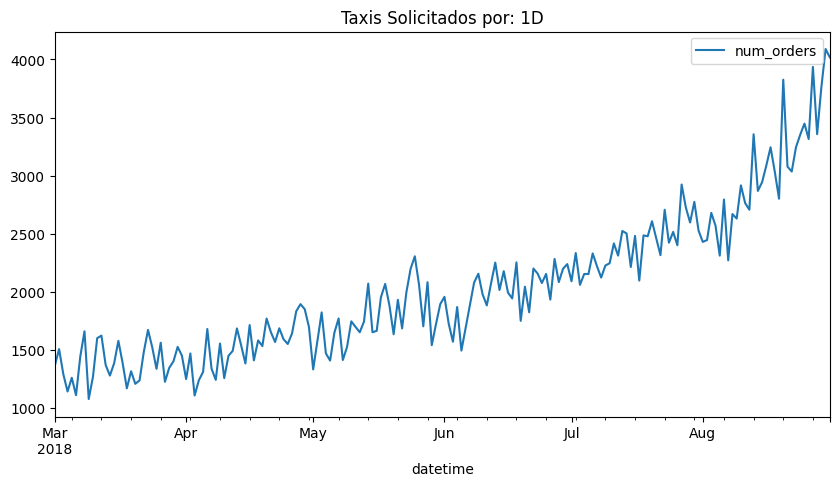

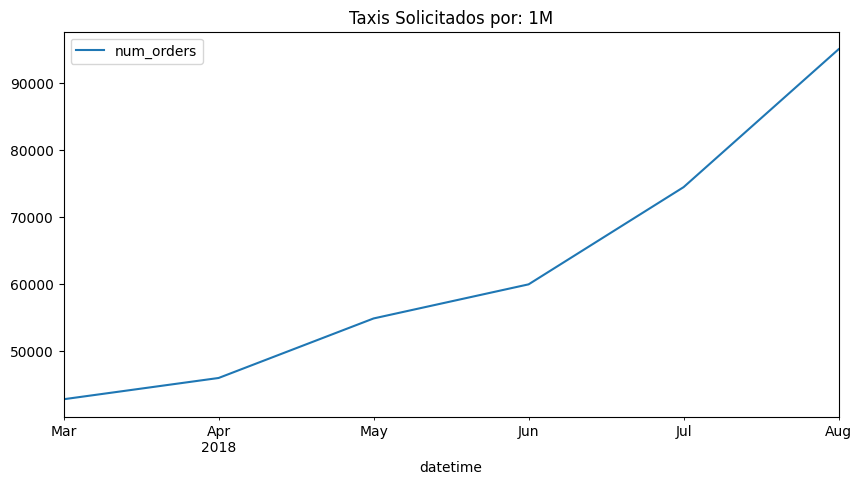

In [8]:
# ejecutar y probar función

plot_taxi_periods(time_periods,data)

<AxesSubplot:title={'center':'Taxis Solicitados por: Hora'}, xlabel='datetime'>

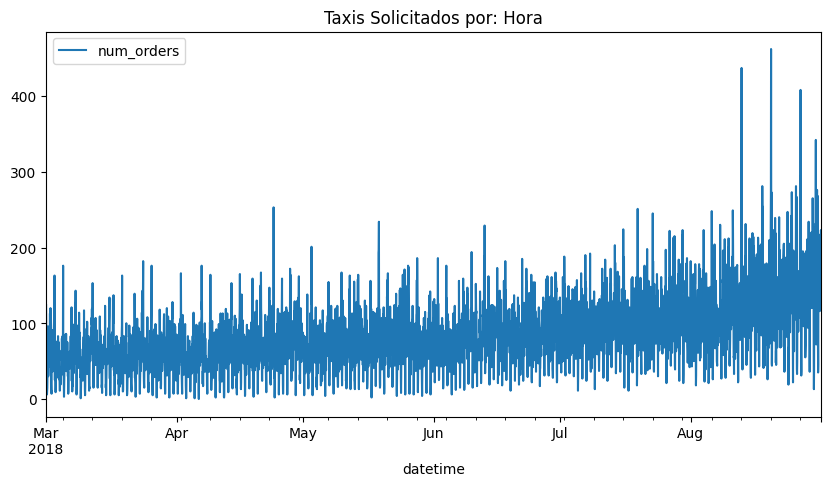

In [9]:
# remuestrar los índices en intervalos de 1 hora '1H' con la suma de los taxis solicitados
# comprobar remuestreo y graficar

data = data.resample('1H').sum()
data.plot(figsize=[10,5], title='Taxis Solicitados por: Hora')

In [10]:
# revisemos cómo queda la tabla

data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Con estos primeros gráficos, podemos ver claramente que hay un incremento sostenido en la cantidad de taxis solicitados durante el año 2018.

## Análisis

Analicemos la estacionalidad, tendencias y residuales de los datos.

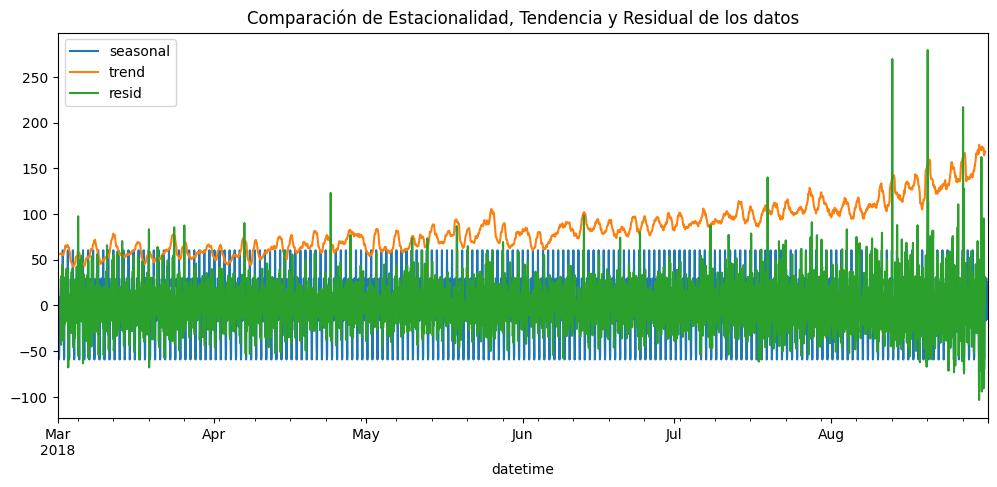

In [11]:
# estacionalidad, tendencia y residual

decomposed = seasonal_decompose(data)
plt.figure(figsize=[12,5])
decomposed.seasonal.plot()
decomposed.trend.plot()
decomposed.resid.plot()
plt.title('Comparación de Estacionalidad, Tendencia y Residual de los datos')
plt.legend()
plt.show()

Podemos observar que los datos muestran una estacionalidad y tendencia bien claras, por lo que los datos están listos para entrenar y probar modelos de regresión para la prediccón de la variable objetivo.

## Formación

Crearemos algunas características adicionales del índice de fechas, agregaremos desfases la media móvil para mejorar el entrenamiento y calidad de la predicción del posterior modelo.

In [12]:
# crear función que cree las características que necesitamos

def make_features(df, max_lag, rolling_mean_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = (df['num_orders'].shift().rolling(rolling_mean_size).mean())
    df['rolling_syd'] = (df['num_orders'].shift().rolling(rolling_mean_size).std())

    return df

In [13]:
# aplicar función al dataset y ver resultados

new_data = make_features(data, 25, 72).dropna()
new_data.head(5)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,rolling_mean,rolling_syd
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-04 00:00:00,75,2018,3,4,6,43.0,63.0,48.0,83.0,30.0,...,9.0,15.0,44.0,64.0,25.0,108.0,163.0,72.0,57.777778,31.488081
2018-03-04 01:00:00,60,2018,3,4,6,75.0,43.0,63.0,48.0,83.0,...,17.0,9.0,15.0,44.0,64.0,25.0,108.0,163.0,57.097222,30.552269
2018-03-04 02:00:00,26,2018,3,4,6,60.0,75.0,43.0,63.0,48.0,...,56.0,17.0,9.0,15.0,44.0,64.0,25.0,108.0,56.750000,30.372221
2018-03-04 03:00:00,42,2018,3,4,6,26.0,60.0,75.0,43.0,63.0,...,73.0,56.0,17.0,9.0,15.0,44.0,64.0,25.0,56.125000,30.537411
2018-03-04 04:00:00,27,2018,3,4,6,42.0,26.0,60.0,75.0,43.0,...,52.0,73.0,56.0,17.0,9.0,15.0,44.0,64.0,55.791667,30.559080


Separemos los datos en los conjuntos de entrenamiento y de prueba en la proporción 90:10.

In [14]:
# separar datos en train y test

train, test = train_test_split(new_data, test_size=0.1, shuffle=False, random_state=1234)

In [15]:
# verificar que los conjuntos no se crucen temporalmente

print('Máxima fecha de entrenamiento',train.index.max())
print('Mínima fecha de prueba',test.index.min())
print('¿¿Las fechas de prueba son mayores a las de entrenamiento??',test.index.min()>train.index.max())

Máxima fecha de entrenamiento 2018-08-13 20:00:00
Mínima fecha de prueba 2018-08-13 21:00:00
¿¿Las fechas de prueba son mayores a las de entrenamiento?? True


In [16]:
# definir características y objetivo

X_train = train.drop('num_orders',1)
y_train = train['num_orders']

X_test = test.drop('num_orders',1)
y_test = test['num_orders']

## Prueba

Ahora podemos crear un modelo de regresión lineal para predecir el número de taxis en la próxima hora y evaluar la calidad de esa predicción.

In [17]:
# crear modelo de regresión lineal, entrenarlo y predecir número de taxis

model_lr = LinearRegression()
model_lr.fit(X_train,y_train)

pred_y_train = model_lr.predict(X_train)
pred_y_test = model_lr.predict(X_test)

In [18]:
# evaluar calidad de la predicción

rmse_train = mean_squared_error(y_train,pred_y_train) ** 0.5
rmse_test = mean_squared_error(y_test,pred_y_test) ** 0.5

print('RMSE Train:', rmse_train)
print('RMSE Test:', rmse_test)


RMSE Train: 25.79686268033564
RMSE Test: 45.539256725322744


Vamos a entrenar y evaluar un modelo de Bosque Aleatorio de Regresión.

In [19]:
# modelo de bosque aleatorio de regresión

model_rfr = RandomForestRegressor(n_estimators=200, max_depth=19, random_state=1234)
model_rfr.fit(X_train, y_train)

pred_y_train_rfr = model_rfr.predict(X_train)
pred_y_test_rfr = model_rfr.predict(X_test)

In [20]:
# evaluar calidad del modelo

rmse_rfr_train = mean_squared_error(y_train,pred_y_train_rfr) ** 0.5
rmse_rfr_test = mean_squared_error(y_test,pred_y_test_rfr) ** 0.5

print('RMSE Train:', rmse_rfr_train)
print('RMSE Test:', rmse_rfr_test)

RMSE Train: 8.860226239815566
RMSE Test: 42.96690659085197


Ahora evaluaremos un modelo de Regresión de Árbol de Decisión.

In [21]:
# modelo de regresión de árbol de decisión

model_dtr = DecisionTreeRegressor(max_depth=11, random_state=1234)
model_dtr.fit(X_train, y_train)

pred_y_train_dtr = model_dtr.predict(X_train)
pred_y_test_dtr = model_dtr.predict(X_test)

In [22]:
# evaluar calidad del modelo

rmse_dtr_train = mean_squared_error(y_train,pred_y_train_dtr) ** 0.5
rmse_dtr_test = mean_squared_error(y_test,pred_y_test_dtr) ** 0.5

print('RMSE Train:', rmse_dtr_train)
print('RMSE Test:', rmse_dtr_test)

RMSE Train: 14.86304932780133
RMSE Test: 66.7725831944925


# Conclusión

Luego preparar y analizar los datos para entrenar diferentes modelos de regresión, modificando los hiperparámetros de desfases y tamaño de la media móvil, obtuvimos que el modelo que tuvo la mejor predicción según la métrica del RMSE fue el Bosque Aleatorio de Regresión con un RMSE de 42.97 bastante menos que el objetivo de 48.

Por lo tanto, es el modelo seleccionado para hacer la predicción de la cantidad de taxis que se necesitarán en la próxima hora en los aeropuertos.

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]  	
Los datos han sido descargados y preparados.
- [ ]  Se ha realizado el paso 2: los datos han sido analizados
- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [ ]  Se han evaluado los modelos. Se expuso una conclusión
- [ ] La *RECM* para el conjunto de prueba no es más de 48